In [2]:
from graphviz import Digraph

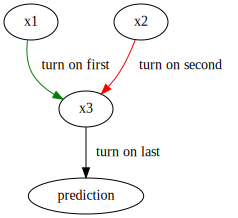

In [23]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('y', 'prediction')

dot.edge('1', '3', 'turn on first', color='green')
dot.edge('2', '3', 'turn on second', color='red')
dot.edge('3', 'y', 'turn on last')
dot

BFS based flow fails because cannot backprop credit to the green and red edge without linearization.

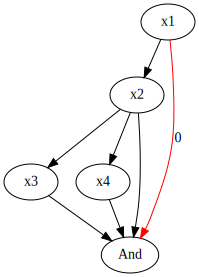

In [28]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And')

dot.edges(['12', '23', '2y', '3y', '24', '4y'])
dot.edge('1', 'y', color='red', label='0')
dot

This fails node first flow (flow0.py) because it assumes the red edge always appear first thus giving 0 contribution to it.

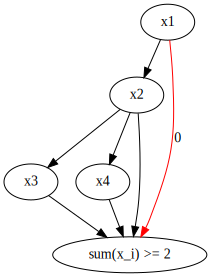

In [32]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'sum(x_i) >= 2')

dot.edges(['12', '23', '2y', '3y', '24', '4y'])
dot.edge('1', 'y', color='red', label='0')
dot

This fails edge first flow (flow1.py) because the red edge can only appear first or last.

This means edge first flow treats direct connections as unbreakable functions; Is this a reasonable assumption? 

Perhaps what we want is **cut invariance**: different cuts of model and data shouldn't affect attribution of edges in the data side of the causal graph. Note that this is a weaker form of implementation invariance. Cut invariance is necessary because otherwise each cut would need a different visualization, which undermines the purpose of studying the flow of information as a single system.

TODO: What does a cut mean? 

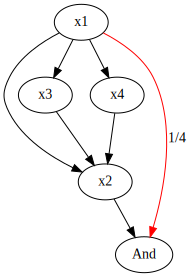

In [33]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And')

dot.edges(['12', '13', '14', '32', '42', '2y'])
dot.edge('1', 'y', color='red', label='1/4')
dot

This fails path first flow (permuting path) because I can make the red edge contribution as little as possible by adding intermediate nodes.

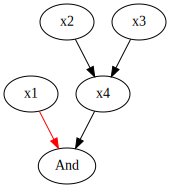

In [25]:
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And')

dot.edges(['4y', '24', '34'])
dot.edge('1', 'y', color='red')
dot

This fails edge first backtrack (trace from the target instead of from the source) because it assumes x1 happens first twice as often as x2 and x3, which is not a justifiable assumption. Note that path first flow would work in this case (there is no path first back tracing b/c path first assumes every path is equally likely).

## Solutution?

Edge first backtrack to single source: Trace from the target to the sources one at a time in the order of node activation

# Axiom: expanding a node shouldn't affect contribution (implementation invariance)

A simple graph


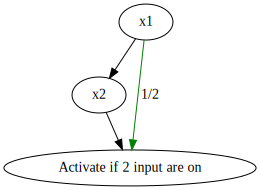

In [26]:
print('A simple graph')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('y', 'Activate if 2 input are on')

dot.edges(['12', '2y'])
dot.edge('1', 'y', color='green', label='1/2')
dot

adding an intermediate node from x1 to x2


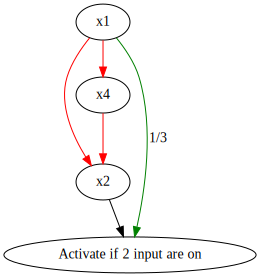

In [25]:
print('adding an intermediate node from x1 to x2')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
# dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'Activate if 2 input are on')

dot.edges(['2y'])
dot.edge('1', 'y', color='green', label='1/3')
dot.edge('1', '4', color='red')
dot.edge('4', '2', color='red')
dot.edge('1', '2', color='red')
dot

This can be resolved by requiring always copy the source node when expanding a computational node.

adding an intermediate node from x1 to x2


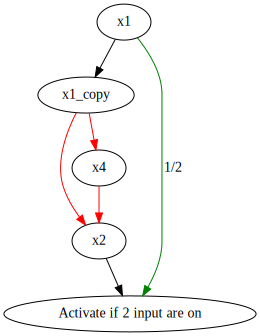

In [36]:
print('adding an intermediate node from x1 to x2')
dot = Digraph()
dot.node('0', 'x1')
dot.node('1', 'x1_copy')
dot.node('2', 'x2')
# dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'Activate if 2 input are on')

dot.edges(['2y'])
dot.edge('0', 'y', color='green', label='1/2')
dot.edge('0', '1')
dot.edge('1', '4', color='red')
dot.edge('4', '2', color='red')
dot.edge('1', '2', color='red')
dot

# DFS Flow violate implmentation invariance

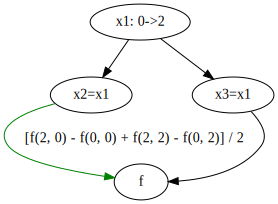

In [24]:
dot = Digraph()
dot.node('1', 'x1: 0->2')
dot.node('2', 'x2=x1')
dot.node('3', 'x3=x1')
dot.node('y', 'f')

dot.edges(['12', '13', '3y'])
dot.edge('2', 'y', color='green', label='[f(2, 0) - f(0, 0) + f(2, 2) - f(0, 2)] / 2')
dot

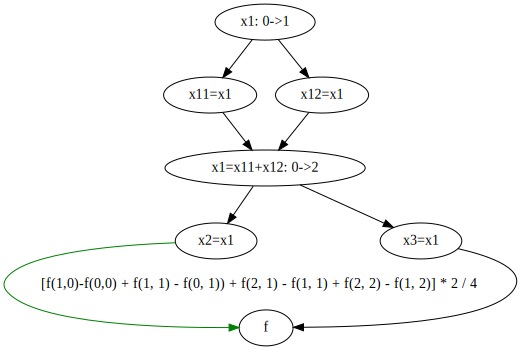

In [26]:
dot = Digraph()
dot.node('0', 'x1: 0->1')
dot.node('m', 'x11=x1')
dot.node('n', 'x12=x1')
dot.node('1', 'x1=x11+x12: 0->2')
dot.node('2', 'x2=x1')
dot.node('3', 'x3=x1')
dot.node('y', 'f')

dot.edges(['0m', '0n', 'n1', 'm1', 
           '12', '13', '3y'])
dot.edge('2', 'y', color='green', label='[f(1,0)-f(0,0) + f(1, 1) - f(0, 1)) + f(2, 1) - f(1, 1) + f(2, 2) - f(1, 2)] * 2 / 4')
dot

We just expand the x1 node. This expansion of the node would break the attribution downstream because x1 can change from 0 to 1 and then 1 to 2 whereas in the previous case x1 only changes from 0 to 2. 

The foundamental problem is that expanding a node will create new intermediate state that is undesirable. If the computational graph is a tree, we are fine because there's only one way to reach a node from the source, therefore void of any intermediate value.

In fact we can show that **no path ordering based edge attribution method is implementation invariant**

# Path ordering based edge attribution is not implementation invariant

We define path ordering based edge attribution methods as methods that derive a payoff function from the function to explain. A payoff function assigns each set of path a real number. One intuitive way to assign path payoff is to view edges on the path as a value mask. At the begining, all nodes of the network take the baseline value except for source nodes. Source nodes take on target values but their impact has yet to reach the output node. Then, turning on a path propagate the influence of the source node on the path to the output, that is to start from the first node of the path, make its value visible to the second node and recompute the second node value, and so on. Our DFS flow is a path ordering based edge attribution method.

For each ordering of paths from source to target, we can define the contribution of a path by its marginal difference on the payoff function of the given order. Path contribution induces an edge contribution by summing the contribution of path through the edge. 

**Implementation invariance** refers to the constrain that revealing (or hiding) the implementation of a node doesn't affect the contribution of edges exterior to the node. We show that no path ordering is implementation invariant given the pay off function we described above.

To see that, consider the following graph (one can add intermediate node on each edge if multi graph is not allowed):

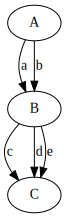

In [27]:
dot = Digraph()
dot.node('A')
dot.node('B')
dot.node('C')

dot.edge('A', 'B', label='a')
dot.edge('A', 'B', label='b')
dot.edge('B', 'C', label='c')
dot.edge('B', 'C', label='d')
dot.edge('B', 'C', label='e')
dot

Note that by implementation invariance, one can combine A and B to form a super node or combine B and C (or combine A, B, and C). If we combine A and B, observe that the path in the original graph [ac, bc] must appear together (no other path in between those two path) because otherwise we would have created new state of B that doesn't exist in the simplified graph. Similarly, [ad, bd] must be atomic (appear together). Same goes for [ae, be]. 

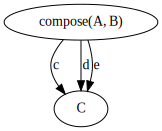

In [29]:
dot = Digraph()
# dot.node('A')
dot.node('B', 'compose(A, B)')
dot.node('C')

# dot.edge('A', 'B', label='a')
# dot.edge('A', 'B', label='b')
dot.edge('B', 'C', label='c')
dot.edge('B', 'C', label='d')
dot.edge('B', 'C', label='e')
dot

By the same argument (an ordering in the simplified graph must be matched by ordering in the expanded graph), we know [ac, ad, ae] and [bc, bd, be] must be atomic. However, one can check that no ordering of input to target paths satisfy these 5 atomic constraints simultaneously. 

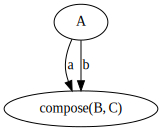

In [30]:
dot = Digraph()
dot.node('A')
dot.node('B', 'compose(B, C)')
# dot.node('C')

dot.edge('A', 'B', label='a')
dot.edge('A', 'B', label='b')
#dot.edge('B', 'C', label='c')
#dot.edge('B', 'C', label='d')
#dot.edge('B', 'C', label='e')
dot

# Possible impossiblity result

The above example motivate us to show something stronger:

Aim to show that implementation invariance is not compatible with
1. efficiency
2. dumminess of path
3. model agnostic (only use first order information)

It is impossible to satisfy all four together.

e.g., DeepLift violates dumminess because it assumes all changed input have an effect on the output; Integrated gradient violates model agnosticity because it requires gradient.

Key: implementation invariance introduces new intermediate states.

Observation:
1. edge not being dummy doesn't imply path is not dummy; this should be a key point in proving the impossibility
2. No axioms can be removed: removing 1 means attributing any path to 0 would satisfy; removing 2 then Deep Lift works; removing 3 makes integrated gradient feasible;

# Can we relax the axioms?


1. Efficiency: $\sum_{i \in \mathcal{P}} \psi_\nu(i) = \nu(\mathcal{P}) - \nu(\{\})  = f(\boldsymbol{x}) - f(\boldsymbol{x'})$
2. Linearity: $\psi_{\alpha u + \beta v} = \alpha \psi_{u} + \beta \psi_{v}$ for any payoff functions $u$ and $v$ and scalars $\alpha$ and $\beta$
3. Dummy player: $\psi_\nu(i) = 0$ if $\nu(S \cup \{i\} )=\nu(S) \forall S \subseteq \mathcal{P} \backslash \{i\}$
4. Symmetry: For $i$, $j$ in $\mathcal{P}$, if $i$ and $j$ share all the nodes up to the cut set and $\nu(S \cup \{j\}) = \nu(S \cup \{i\})$ for all $S \subseteq \mathcal{P}$, then $\psi_\nu(i) = \psi_\nu(j)$
5. Cut invariance: for a fixed G, take arbitrary model boundaries $C1=(D1, M1)$ and $C2=(D2, M2)$, every path in $\text{paths}(D1) \cap \text{paths}(D2)$ have the same attribution with respect to the two cuts.
\end{enumerate}

- Can we have 1-4 without 5: No. Consider the following two graphs: all non terminal nodes are copy of their parents, node colored as orange are in the data side of the boundary. The two attributions at different boundaries satisfy 1-4, but fails 5.

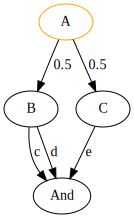

In [39]:
dot = Digraph()
dot.node('A', color='orange')
dot.node('B')
dot.node('C')
dot.node('D', 'And')

dot.edge('A', 'B', label='0.5')
dot.edge('A', 'C', label='0.5')
dot.edge('B', 'D', label='c')
dot.edge('B', 'D', label='d')
dot.edge('C', 'D', label='e')
dot

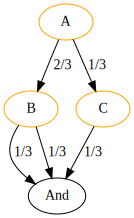

In [40]:
dot = Digraph()
dot.node('A', color='orange')
dot.node('B', color='orange')
dot.node('C', color='orange')
dot.node('D', 'And')

dot.edge('A', 'B', label='2/3')
dot.edge('A', 'C', label='1/3')
dot.edge('B', 'D', label='1/3')
dot.edge('B', 'D', label='1/3')
dot.edge('C', 'D', label='1/3')
dot

- Can we have 1-3, 5 without 4: No. Consider the same graph: as long as edge a and b has combined attribution of $0.5$, it will satisfy axioms 1 to 3 and 5, but may fail 4. This means 1-3 and 5 is not sufficient to determine a unique attribution.

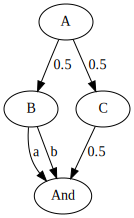

In [43]:
dot = Digraph()
dot.node('A')
dot.node('B')
dot.node('C')
dot.node('D', 'And')

dot.edge('A', 'B', label='0.5')
dot.edge('A', 'C', label='0.5')
dot.edge('B', 'D', label='a')
dot.edge('B', 'D', label='b')
dot.edge('C', 'D', label='0.5')
dot

- Can we relax 5: No. Relaxing 5 to only require edge contribution to be invariant is insufficient because it places only $\sum_{n \in Nodes(G)} \text{OutDegree}(n)$ constraints on possible $\Pi_{n \in Nodes(G)} \text{OutDegree}(n)$ variables (paths), which is underdetermined. Also, cut invariance is with respect to the explanation unit. Since the explanation unit is path, it is more natural as well.